This notebook is actually a copy of `gaiadr2_icrf1_comparison.ipynb`, but I limit the Gaia sample to $G<18.7$.

In [29]:
from astropy.table import Table, join, Column
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_format = "svg"
import sys

# My modules
from my_progs.catalog.vsh_deg1_cor import vsh_deg01_fitting
from my_progs.catalog.vsh_deg2_cor import vsh_deg02_fitting, residual_calc02
from my_progs.catalog.pos_diff import nor_sep_calc, pos_diff_calc
from my_progs.catalog.pos_err import pos_err_calc
from my_progs.catalog.write_output import print_vsh1_corr, print_vsh2_corr
from my_progs.stat_func.rms_calc import rms_calc

In [30]:
# Read Gaia DR2 IERS quasar data
from my_progs.catalog.read_gaia import read_dr2_iers
gaiadr2 = read_dr2_iers()

# A selection on the G magnitude
bgt_mask = (gaiadr2["phot_g_mean_mag"] < 18.7)
gaiadr2 = gaiadr2[bgt_mask]

# Read ICRF1 catalog
from my_progs.catalog.read_icrf import read_icrf1
icrf1 = read_icrf1()

# Crossmatch among these three catalogs
common_source = join(icrf1, gaiadr2, keys="iers_name", table_names=["icrf1", "gaiadr2"]) 

In [31]:
# The positonal offset for common sources between GaiaDR2 and ICRF2.
[dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov,
 ang_sep, X_a, X_d, X] = pos_diff_calc(
    common_source["ra_icrf1"], common_source["ra_err_icrf1"],
    common_source["dec_icrf1"], common_source["dec_err_icrf1"],
    common_source["ra_dec_corr_icrf1"],
    common_source["ra_gaiadr2"], common_source["ra_err_gaiadr2"],
    common_source["dec_gaiadr2"], common_source["dec_err_gaiadr2"],
    common_source["ra_dec_corr_gaiadr2"])

common_source.add_columns(
    [dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov, ang_sep, X_a, X_d, X],
    names=["dra", "ddec", "dra_err", "ddec_err", "dra_ddec_cov",
           "ang_sep", "nor_dra",  "nor_ddec", "nor_sep"])

common_source["dra"].unit = u.mas
common_source["ddec"].unit = u.mas
common_source["dra_err"].unit = u.mas

common_source.sort("dec_icrf1")

In [32]:
common_source

icrf_name,iers_name,type,ra_icrf1,dec_icrf1,si_s,si_x,ra_err_icrf1,dec_err_icrf1,pos_err_icrf1,ra_dec_corr_icrf1,mean_obs,beg_obs,end_obs,nb_sess,nb_del,source_id,ra_gaiadr2,ra_err_gaiadr2,dec_gaiadr2,dec_err_gaiadr2,pos_err_gaiadr2,parallax,parallax_err,pmra,pmra_err,pmdec,pmdec_err,ra_dec_corr_gaiadr2,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,dra,ddec,dra_err,ddec_err,dra_ddec_cov,ang_sep,nor_dra,nor_ddec,nor_sep
,,,deg,deg,,,mas,mas,mas,,,,,,,,deg,mas,deg,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,mag,mag,mag,mas,mas,mas,mas,,deg,deg,deg,deg
str16,str8,str1,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64
J161749.2-771718,1610-771,O,244.4553180875,-77.288463175,--,--,0.7888528257541545,0.9199999999999999,0.9199999999999999,0.0,2449185.5,2447627.0,2449912.3,144,1849,5780473991219814400,244.45531880826925,0.11609338103348579,-77.28846333115271,0.10601774050321344,0.11943908392921739,0.06822795354300881,0.135264039375935,-0.25152992826355175,0.21281172410075863,0.07561600762710302,0.2382647111065882,0.12546216,-0.16432452,-0.29263145,-0.120895825,-0.13841678,-0.059810136,-0.17181784,-0.2048508,0.043494932,0.18203403,264,18.073807,18.839888,17.136702,-0.570959870649863,0.5621497507490858,0.797349643393725,0.9260884198074213,0.00154418298293584,0.8012537152236909,-0.7160721464923606,0.6070152036519191,0.9397066543202065
J031155.2-765150,0312-770,C,47.98020972916666,-76.86412456388888,--,--,0.7533705884121248,0.6699999999999999,0.8693195021200416,0.476,2448768.6,2448111.4,2449896.1,3,17,4638902749442043904,47.98020934782005,0.048803474404810344,-76.86412438994172,0.0430857559421685,0.049995365446954765,-0.1503783526142562,0.04858376473022581,0.03664213274736488,0.10323079018004093,-0.11542304592080613,0.0900893592383438,0.1308782,0.18527538,-0.24178655,-0.19408266,0.12238452,-0.12262027,-0.13964932,0.1772241,-0.19537102,0.17712782,229,16.409534,16.541353,15.860948,0.3119949171191067,-0.6262097656417609,0.7549496821632632,0.6713839306723896,0.24054015016409963,0.6996281147104277,0.41326584339383243,-0.9327148551419948,1.3473937939253715
J020213.6-762003,0202-765,C,30.55705924166666,-76.334182375,--,--,9.685416494768821,5.919999999999999,9.744791837696775,0.145,2448780.7,2448111.4,2449896.1,2,8,4637046842533931776,30.55705734415762,0.06027591383612322,-76.3341839897547,0.04960481308839847,0.06049979400299211,0.0608745758564989,0.056032513682111866,-0.056412062101460624,0.11337788519537607,-0.0010447887314445914,0.10008014153723525,0.06023459,0.23434557,-0.39555797,-0.10975848,0.07054903,-0.05942733,-0.34338602,-0.01287006,-0.21806069,0.07997096,219,16.686905,16.698038,16.254648,1.613889384010251,5.813116951003394,9.685604052558041,5.920207820463866,8.314141619058349,6.032989941137312,0.16662764400161606,0.9819109611168885,0.9822169239394251
J084127.0-754027,0842-754,C,130.36264536666664,-75.67440855000001,--,--,10.959991751647895,7.3999999999999995,11.849522121128794,-0.514,2448205.8,2448111.4,2448866.3,2,8,5216426317174691200,130.36264855728805,0.04608879190945817,-75.67440928549293,0.05163697420772348,0.05164790310908927,0.0025825035973819537,0.050646239269593996,0.10808844241499357,0.09803616294342181,0.07290322520789105,0.10821843300589691,0.010405957,-0.008580931,-0.32339633,7.02274e-05,0.13113391,0.029970845,-0.12241238,0.21687211,-0.19025072,-0.017303266,227,16.865795,16.929014,16.509924,-2.8420603621283993,2.64777450524889,10.960088657165578,7.40018015842218,-41.687399861579614,3.8843296632272875,-0.2593099792372841

In [33]:
# Seperate the sources into the "defining ","Candidates", and "Others".
# Defining sources
mask_def = (common_source["type"] == "D")
com_def = common_source[mask_def]

# Candidate sources
mask_can = (common_source["type"] == "C")
com_can = common_source[mask_can]

# Other sources
mask_oth =  (common_source["type"] == "O")
com_oth = common_source[mask_oth]

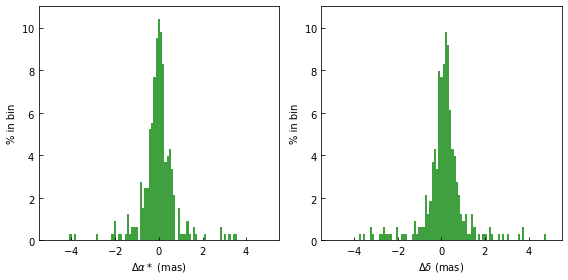

In [34]:
# Difference in RA and decl.
bins_array = np.linspace(-5, 5, 100)
weights = np.ones_like(dRA) * 100. / dRA.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dRA, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(dDC, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 11, 2))
ax1.set_yticks(np.arange(0, 11, 2))

ax0.set_ylim([0, 11])
ax1.set_ylim([0, 11])

ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

In [35]:
std_ra = np.std(dRA)
std_dec = np.std(dDC)
_, wrms_ra, _ = rms_calc(dRA, dRA_err)
_, wrms_dec, _ = rms_calc(dDC, dDC_err)

std_ra, std_dec, wrms_ra, wrms_dec

(955.4422165949093, 357.34731346175596, 1.5780042017263565, 0.993665154446932)

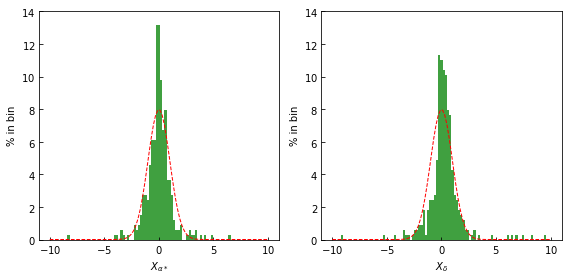

In [36]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(dRA) * 100. / dRA.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(X_a, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(X_d, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylim([0, 13])
ax1.set_ylim([0, 13])

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 15, 2))
ax1.set_yticks(np.arange(0, 15, 2))

fig.tight_layout()
plt.show()

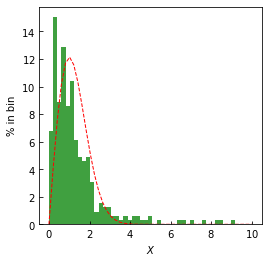

In [37]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X) * 100. / X.size

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(X, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.set_xlabel("$X$")
ax.set_ylabel("% in bin")

plt.show()

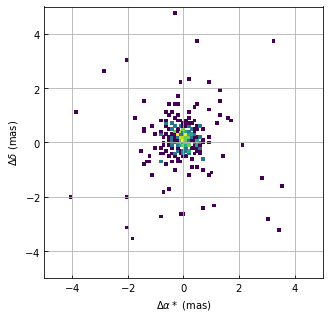

In [38]:
from matplotlib import colors

fig, ax = plt.subplots(figsize=(5, 5))

bins = np.linspace(-5, 5, 100)

# We can increase the number of bins on each axis
ax.hist2d(dRA, dDC, bins, norm=colors.LogNorm())

ax.set_xlabel("$\Delta\\alpha*$ (mas)")
ax.set_ylabel("$\Delta\\delta$ (mas)")

ax.grid(True)

plt.show()

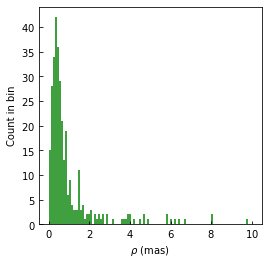

In [39]:
# Distribution of angular separation
bins_array = np.linspace(0, 10, 100)

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(ang_sep, bins_array, facecolor="g", alpha=0.75)

ax.set_xlabel("$\\rho$ (mas)")
ax.set_ylabel("Count in bin")

plt.show()

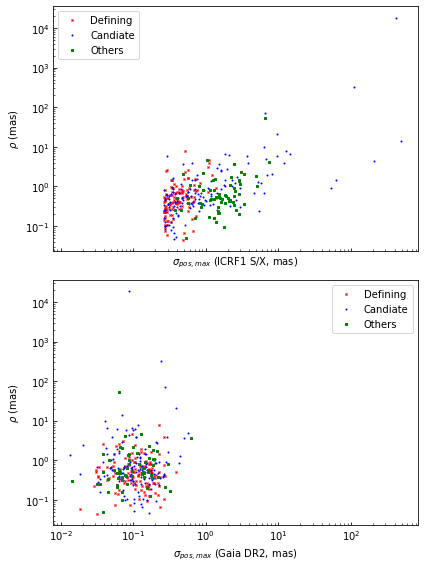

In [40]:
# Angular position difference vs. positional uncertainty
fig, (ax0, ax1) = plt.subplots(figsize=(6, 8), nrows=2, sharex=True)

ax0.plot(com_def["pos_err_icrf1"],
         com_def["ang_sep"], "rx", ms=2, label="Defining")
ax1.plot(com_def["pos_err_gaiadr2"],
         com_def["ang_sep"], "rx", ms=2, label="Defining")

ax0.plot(com_can["pos_err_icrf1"],
         com_can["ang_sep"], "b.", ms=2, label="Candiate")
ax1.plot(com_can["pos_err_gaiadr2"],
         com_can["ang_sep"], "b.", ms=2, label="Candiate")

ax0.plot(com_oth["pos_err_icrf1"],
         com_oth["ang_sep"], "gs", ms=2, label="Others")
ax1.plot(com_oth["pos_err_gaiadr2"],
         com_oth["ang_sep"], "gs", ms=2, label="Others")

ax0.set_xscale("log")
ax0.set_yscale("log")
ax1.set_xscale("log")
ax1.set_yscale("log")

ax0.set_xlabel("$\sigma_{pos,max}$ (ICRF1 S/X, mas)")
ax0.set_ylabel("$\\rho$ (mas)")
ax1.set_xlabel("$\sigma_{pos,max}$ (Gaia DR2, mas)")
ax1.set_ylabel("$\\rho$ (mas)")


ax0.legend()
ax1.legend()

fig.tight_layout()
plt.show()

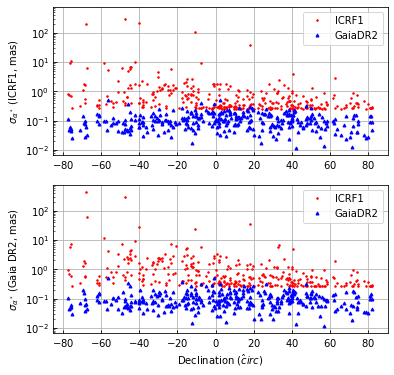

In [59]:
# Positional uncertainty for common sources as a function of declination
fig, (ax0, ax1) = plt.subplots(figsize=(6,6), nrows=2, sharey=True)

ax0.plot(common_source["dec_icrf1"], common_source["ra_err_icrf1"], "r.", ms=3, label="ICRF1")
ax0.plot(common_source["dec_gaiadr2"], common_source["ra_err_gaiadr2"], "b^", ms=3, label="GaiaDR2")

ax0.set_yscale("log")
ax0.set_ylabel("$\sigma_{\\alpha^*}$ (ICRF1, mas)")
ax0.grid()

ax1.plot(common_source["dec_icrf1"], common_source["dec_err_icrf1"], "r.", ms=3, label="ICRF1")
ax1.plot(common_source["dec_gaiadr2"], common_source["dec_err_gaiadr2"], "b^", ms=3, label="GaiaDR2")
ax1.set_yscale("log")
ax1.set_ylabel("$\sigma_{\\alpha^*}$ (Gaia DR2, mas)")
ax1.set_xlabel("Declination ($\^circ$)")

ax1.grid()
ax0.legend()
ax1.legend()

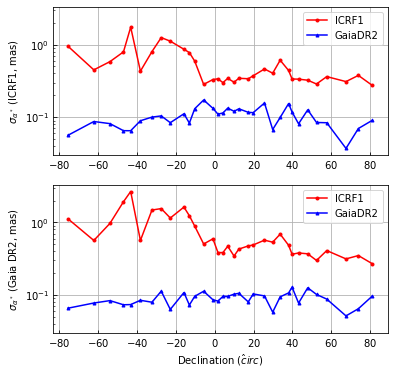

In [60]:
binsize = 10

comsou_bin = np.trunc(np.arange(len(common_source)) / binsize)
comsou_grouped = common_source.group_by(comsou_bin)
com_binned = comsou_grouped.groups.aggregate(np.median)

fig, (ax0, ax1) = plt.subplots(figsize=(6,6), nrows=2, sharey=True)

ax0.plot(com_binned["dec_icrf1"], com_binned["ra_err_icrf1"], "ro-", ms=3, label="ICRF1")
ax0.plot(com_binned["dec_gaiadr2"], com_binned["ra_err_gaiadr2"], "b^-", ms=3, label="GaiaDR2")

ax0.set_yscale("log")
ax0.set_ylabel("$\sigma_{\\alpha^*}$ (ICRF1, mas)")
ax0.grid()

ax1.plot(com_binned["dec_icrf1"], com_binned["dec_err_icrf1"], "ro-", ms=3, label="ICRF1")
ax1.plot(com_binned["dec_gaiadr2"], com_binned["dec_err_gaiadr2"], "b^-", ms=3, label="GaiaDR2")
ax1.set_yscale("log")
ax1.set_ylabel("$\sigma_{\\alpha^*}$ (Gaia DR2, mas)")
ax1.set_xlabel("Declination ($\^circ$)")

ax1.grid()
ax0.legend()
ax1.legend()

Then I investigate the systematics through the 16-parameters transformation.

In [42]:
# Try with all the sources
# Transform columns into np.array
dra = np.array(common_source["dra"])
ddec = np.array(common_source["ddec"])
dra_err = np.array(common_source["dra_err"])
ddec_err = np.array(common_source["ddec_err"])
ra_rad = np.array(common_source["ra_icrf1"].to(u.radian))
dec_rad = np.array(common_source["dec_icrf1"].to(u.radian))
dra_ddec_cov = np.array(common_source["dra_ddec_cov"])

# Transformation parameters
# l_max = 1
w1_all, sig1_all, corrcoef1_all = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# l_max = 2
w2_all, sig2_all, corrcoef2_all = vsh_deg02_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# mas -> uas
w1 = w1_all * 1.e3
sig1 = sig1_all * 1.e3
w2 = w2_all * 1.e3
sig2 = sig2_all * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_all, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_all, deci_digit=1, included_one=False)

Estimates (   326 sources)
--------------------------------------------------------------------------------------------
               Rotation [uas]                                   Glide [uas]               
               x             y             z               x             y             z
--------------------------------------------------------------------------------------------
l_max=1  +925636 +/- 97663  +573103 +/- 97346  -407037 +/- 89733    -465171 +/- 98935  +901786 +/- 87631  +389009 +/- 99449
l_max=2  +681984 +/- 82856  +480136 +/- 79364  -384701 +/- 74688    -263326 +/- 81192  +813243 +/- 70520  +663938 +/- 82284
--------------------------------------------------------------------------------------------

Quadrupolar term Estimate Error
---------------- -------- -----
            ER22   -47163 48524
            EI22   252097 47107
            ER21   -69921 94397
            EI21  -557911 96476
             E20  -820054 90780
            MR22  -361508 50267
         

In [43]:
# The last step is to save the 16 transformation parameters for further use.

vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2, sig2], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf1_gaiadr2_bgt_vsh02_all.log",
             format="ascii", overwrite=True)

For a `clean` sample, I re-estimate the parameters.

In [44]:
# Remove the outlier (consider the normalized separation)
N = len(common_source)
X0 = np.sqrt(np.log(N) * 2)
# X0 = 3.41

print("There are %d sources.\n"
      "When X >= %.2f, the number of the outlier is smaller than 1." % (N, X0))

mask = ((common_source["nor_sep"] <= X0)
        & (common_source["ang_sep"] < 10))

# Table of a clean sample
com_clean = common_source[mask]
N1 = len(com_clean)
print("After elimination, there are %d sources in the clean sample." % N1)
print("The outlier rate is %.0f%%." % ((N-N1)/N*100))

There are 326 sources.
When X >= 3.40, the number of the outlier is smaller than 1.
After elimination, there are 298 sources in the clean sample.
The outlier rate is 9%.


In [45]:
# Transform columns into np.array
dra = np.array(com_clean["dra"])
ddec = np.array(com_clean["ddec"])
dra_err = np.array(com_clean["dra_err"])
ddec_err = np.array(com_clean["ddec_err"])
ra_rad = np.array(com_clean["ra_icrf1"].to(u.radian))
dec_rad = np.array(com_clean["dec_icrf1"].to(u.radian))
dra_ddec_cov = np.array(com_clean["dra_ddec_cov"])

In [46]:
# Transformation parameters
# l_max = 1
w1_cln, sig1_cln, corrcoef1_cln = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# l_max = 2
w2_cln, sig2_cln, corrcoef2_cln = vsh_deg02_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None", flog=sys.stdout)

# mas -> uas
w1 = w1_cln * 1.e3
sig1 = sig1_cln * 1.e3
w2 = w2_cln * 1.e3
sig2 = sig2_cln * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_cln, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_cln, deci_digit=1, included_one=False)

# apriori statistics (weighted)
#         mean for RA:     -0.082 
#         wrms for RA:      1.035 
#          std for RA:      1.030 
#        mean for Dec:      0.113 
#        wrms for Dec:      0.905 
#         std for Dec:      0.896 

# apriori reduced Chi-square for:      0.771
# posteriori statistics  of vsh01 fit (weighted)
#         mean for RA:     -0.095 
#          rms for RA:      1.021 
#          std for RA:      1.014 
#        mean for Dec:     -0.049 
#         rms for Dec:      0.905 
#         std for Dec:      0.902 

# posteriori reduced Chi-square for:      0.671
# goodness-of-fit is      1.000
Estimates (   298 sources)
--------------------------------------------------------------------------------------------
               Rotation [uas]                                   Glide [uas]               
               x             y             z               x             y             z
------------------------------------------------------------------------

Save the results for future use.

In [47]:
# The last step is to save the 16 transformation parameters for further use.

vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2, sig2], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf1_gaiadr2_bgt_vsh02.log",
             format="ascii", overwrite=True)

Then I check the residuals of positional offsets.

In [48]:
# Remove the systematics
RA = np.array(common_source["ra_icrf1"].to(u.radian))
DE = np.array(common_source["dec_icrf1"].to(u.radian))

dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_cln)
# dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_all)

# Now re-calculate the normalized difference
ang_sep_ns, Xa_ns, Xd_ns, X_ns = nor_sep_calc(
    dra_ns, dRA_err, ddec_ns, dDC_err, dRA_dDC_cov/dRA_err/dDC_err)

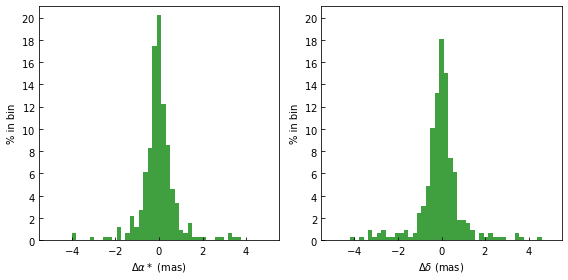

In [49]:
# Difference in RA and decl.
bins_array = np.linspace(-5, 5, 50)
weights = np.ones_like(dra_ns) * 100. / dra_ns.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dra_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(ddec_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 23, 2))
ax1.set_yticks(np.arange(0, 23, 2))

ax0.set_ylim([0, 21])
ax1.set_ylim([0, 21])

ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

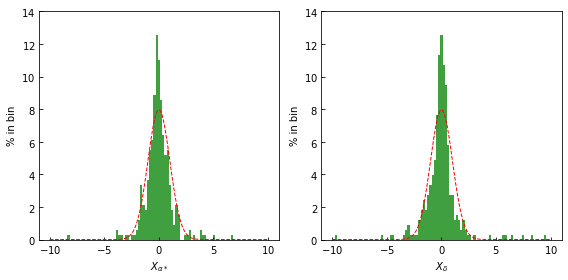

In [50]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(Xa_ns) * 100. / Xa_ns.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(Xa_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(Xd_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 15, 2))
ax1.set_yticks(np.arange(0, 15, 2))

fig.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

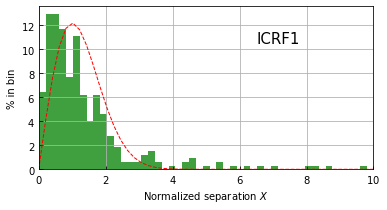

In [51]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X_ns) * 100. / X_ns.size

fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(X_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.text(6.5, 10.5, "ICRF1", fontsize=15)

ax.set_xlim([0, 10])
ax.set_xlabel("Normalized separation $X$")
ax.set_ylabel("% in bin")
ax.grid()

plt.savefig("../plots/x_icrf1_gaiadr2_bgt.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


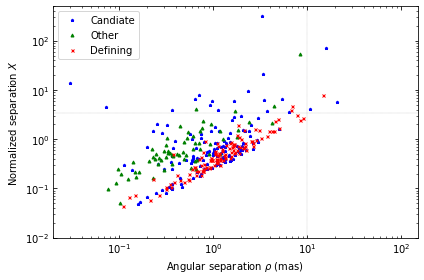

In [52]:
# Angular separation vs. normalized separation
fig, ax = plt.subplots()

ax.plot(com_can["nor_sep"], com_can["ang_sep"],
         "b*", ms=3, label="Candiate")
ax.plot(com_oth["nor_sep"], com_oth["ang_sep"],
         "g^", ms=3, label="Other")
ax.plot(com_def["nor_sep"], com_def["ang_sep"],
         "rx", ms=3, label="Defining")

ax.vlines(10, 0.01, 500, colors="k", linestyles="dashed", lw=0.1)
ax.hlines(X0, 0.02, 150, colors="k", linestyles="dashed", lw=0.1)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel("Normalized separation $X$")
ax.set_xlabel("Angular separation $\\rho$ (mas)")

ax.set_xlim([0.02, 150])
ax.set_ylim([0.01, 500])
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.legend(loc="upper left")
fig.tight_layout()

plt.savefig("../plots/separation_icrf1_gaiadr2_bgt.eps")